# Guía Práctica de ML
En esta guía haremos una progresión desde los modelos más simples posibles, quizás con más errores, a los modelos de ML más complejos y utilizados. <br />
Esta progresión también tiene la intención de mostrar el recorrido del ML en profundidad y especificidad

In [835]:
# Liberrías standard
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#scipy.stats
import scipy.stats as stats
from scipy.stats.mstats import winsorize

# Scikit-learn Utilidades
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer

# Scikit-learn Modelos
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

# Scikit-learn Métricas y Selección de Modelos
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score

In [836]:
df = pd.read_csv('./data/house_data.csv')
df

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,NaN,NaN,Yarra,-37.79960,144.99840,Northern Metropolitan,4019.0
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra,-37.80790,144.99340,Northern Metropolitan,4019.0
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,2.0,0.0,134.0,150.0,1900.0,Yarra,-37.80930,144.99440,Northern Metropolitan,4019.0
3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,4/03/2017,2.5,3067.0,...,2.0,1.0,94.0,NaN,NaN,Yarra,-37.79690,144.99690,Northern Metropolitan,4019.0
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,...,1.0,2.0,120.0,142.0,2014.0,Yarra,-37.80720,144.99410,Northern Metropolitan,4019.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13575,Wheelers Hill,12 Strada Cr,4,h,1245000.0,S,Barry,26/08/2017,16.7,3150.0,...,2.0,2.0,652.0,NaN,1981.0,NaN,-37.90562,145.16761,South-Eastern Metropolitan,7392.0
13576,Williamstown,77 Merrett Dr,3,h,1031000.0,SP,Williams,26/08/2017,6.8,3016.0,...,2.0,2.0,333.0,133.0,1995.0,NaN,-37.85927,144.87904,Western Metropolitan,6380.0
13577,Williamstown,83 Power St,3,h,1170000.0,S,Raine,26/08/2017,6.8,3016.0,...,2.0,4.0,436.0,NaN,1997.0,NaN,-37.85274,144.88738,Western Metropolitan,6380.0
13578,Williamstown,96 Verdon St,4,h,2500000.0,PI,Sweeney,26/08/2017,6.8,3016.0,...,1.0,5.0,866.0,157.0,1920.0,NaN,-37.85908,144.89299,Western Metropolitan,6380.0


In [837]:
df.columns

Index(['Suburb', 'Address', 'Rooms', 'Type', 'Price', 'Method', 'SellerG',
       'Date', 'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car',
       'Landsize', 'BuildingArea', 'YearBuilt', 'CouncilArea', 'Lattitude',
       'Longtitude', 'Regionname', 'Propertycount'],
      dtype='object')

## Nuestro objetivo del modelo es predecir el Precio
Para eso vamos a ver cuáles son las variables correlacionadas, para trabajar con esas

<Axes: >

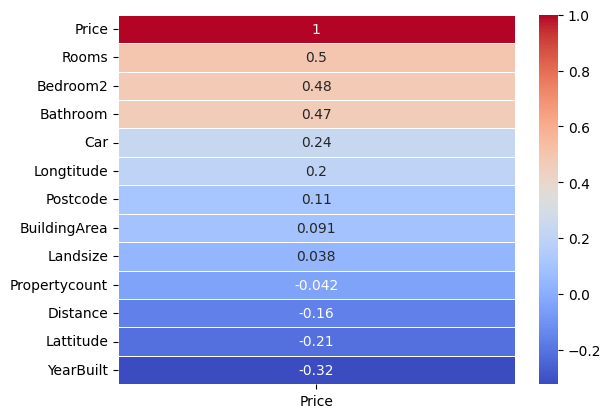

In [838]:
price_corr = df.corr(numeric_only=True)['Price'].sort_values(ascending=False)

sns.heatmap(price_corr.to_frame(), annot=True, cmap='coolwarm', linewidths=0.5)

Algo que refleja la data es que hay relación entre Precio y número de Rooms. La segunda variable es Bedroom2, osea que haya más de una habitación. <br />
Nos aporta más de lo mismo, así pudiendola eliminar del análisis por redundancia

In [839]:
corr_value = df[['Rooms', 'Bedroom2']].corr().iloc[0, 1]
print(f'Correlación entre Rooms y Bedroom2: {corr_value}')

Correlación entre Rooms y Bedroom2: 0.9441902739606949


## Elección de variables
Por ahora eligiremos Rooms, Bathroom, Landsize, BuildingArea, YearBuilt, Lattitude y Longitude. El proceso es iterativo y ciertamente puede haber errores que iremos descubriendo

In [840]:
house_features = ['Rooms', 'Bathroom', 'Landsize', 'BuildingArea', 'YearBuilt', 'Lattitude', 'Longtitude']

## Limpieza de nuestros datos

In [841]:
df_clean = df[[
    #'Suburb', 'Address',
     'Rooms', 
    #  'Type',
       'Price',
        #  'Method', 'SellerG',
    #    'Date', 'Distance', 'Postcode', 'Bedroom2', 
       'Bathroom',
        #  'Car',
       'Landsize', 'BuildingArea', 'YearBuilt', 
    #    'CouncilArea',
         'Lattitude', 'Longtitude',
        #    'Regionname', 'Propertycount'
]]

In [842]:
print(df_clean[house_features].isna().sum())
print(df_clean['Price'].isna().sum())

Rooms              0
Bathroom           0
Landsize           0
BuildingArea    6450
YearBuilt       5375
Lattitude          0
Longtitude         0
dtype: int64
0


Lo que nos interesa de esos datos faltantes es que nos podríamos estar perdiendo. Quizás son datos que sean díficiles de determinar, y no podemos hacer una imputación, o datos en los que sí podemos hacer una imputación y agregarle exactitud al modelo al tener más samples. <br />
También tenemos que observar si son datos que condicionarían nuestro modelo de ML y estaríamos incurriendo en un Data Leakage. No es el caso.

In [843]:
rows_with_multiple_missing = df_clean[df_clean.isna().sum(axis=1) > 1]

print(f"Número de filas con más de 1 columna faltante : {len(rows_with_multiple_missing)}")

rows_with_multiple_missing

Número de filas con más de 1 columna faltante : 5103


,Rooms,Price,Bathroom,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude
0,2,1480000.0,1.0,202.0,NaN,NaN,-37.79960,144.99840
3,3,850000.0,2.0,94.0,NaN,NaN,-37.79690,144.99690
5,2,941000.0,1.0,181.0,NaN,NaN,-37.80410,144.99530
8,1,300000.0,1.0,0.0,NaN,NaN,-37.80080,144.99730
10,2,700000.0,2.0,0.0,NaN,NaN,-37.81100,145.00670
...,...,...,...,...,...,...,...,...
13566,4,1250000.0,2.0,986.0,NaN,NaN,-37.84679,145.20051
13567,5,1316000.0,3.0,696.0,NaN,NaN,-37.73501,145.08341
13569,4,1323000.0,2.0,551.0,NaN,NaN,-37.87608,145.22390
13570,3,970000.0,2.0,674.0,NaN,NaN,-37.88360,145.22805


In [844]:
df_clean = df_clean.dropna(thresh=df_clean.shape[1] - 1)

In [845]:
df_clean.isna().sum()

Rooms              0
Price              0
Bathroom           0
Landsize           0
BuildingArea    1347
YearBuilt        272
Lattitude          0
Longtitude         0
dtype: int64

## Análisis Bivariado
Este gráfico para ver en un scatter plot nos dice como se relacionan las variables. <br />
Detectamos como se visualiza en el gráfico valores extremos, pero si los eliminamos ya sea con métodos de IQR o con winsorizing, perdemos precisión en el modelo. <br /> 
Igualmente en el proceso iterativo, detectamos que BuildingArea estaba tomando mucha importancia, entonces le aplicamos winsorizing. <br/>
Por eso lo único que haremos, es en el Pipeline agregarle un RobustScaler

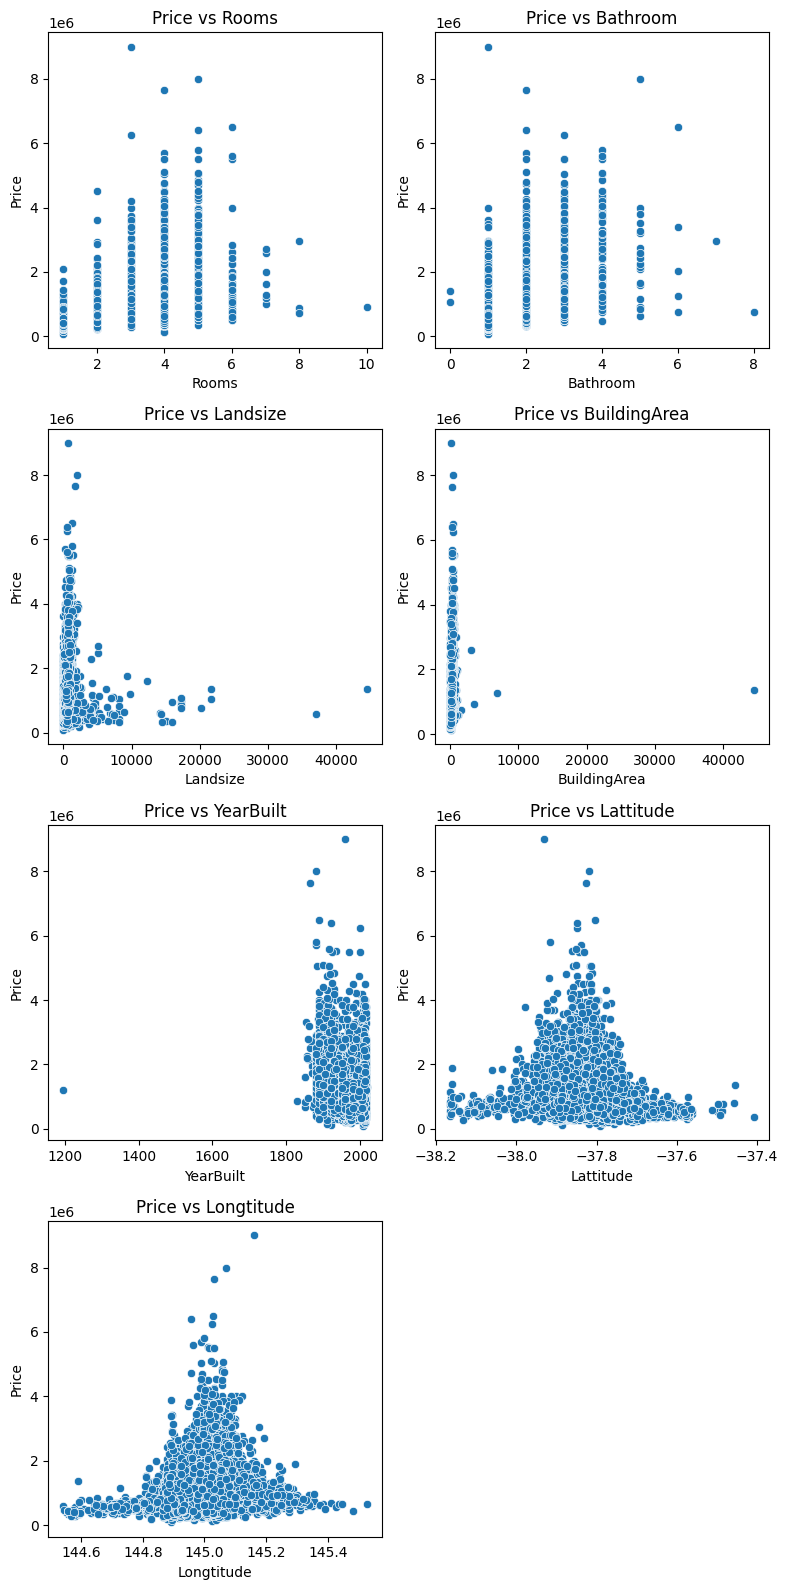

In [846]:
target = 'Price'
features = [col for col in df_clean.columns if col != target]
n_cols = 2 
n_rows = int(np.ceil(len(features) / n_cols)) 

fig, axes = plt.subplots(n_rows, n_cols, figsize=(8, 4 * n_rows)) 
axes = axes.flatten() 

for i, feature in enumerate(features):
    sns.scatterplot(x=df_clean[feature], y=df_clean[target], ax=axes[i])
    axes[i].set_title(f'{target} vs {feature}', fontsize=12)
    axes[i].set_xlabel(feature, fontsize=10)
    axes[i].set_ylabel(target, fontsize=10)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])  

plt.tight_layout()
plt.show()

In [847]:

columns_to_winsorize = ['BuildingArea']
limits = [0.01, 0.01]

df_clean[columns_to_winsorize] = df_clean[columns_to_winsorize].apply(
    lambda col: pd.Series(winsorize(col.to_numpy(), limits=limits))
)


Haremos imputación de las columnas, pero cuando no están ambas faltantes. Dado el tipo de valores faltantes, les imputaré la moda.

In [848]:
imputer = SimpleImputer(strategy='most_frequent')
df_clean[['YearBuilt', 'BuildingArea']] = imputer.fit_transform(df_clean[['YearBuilt', 'BuildingArea']])
df_clean.isna().sum()

Rooms           0
Price           0
Bathroom        0
Landsize        0
BuildingArea    0
YearBuilt       0
Lattitude       0
Longtitude      0
dtype: int64

En una iteración me di cuenta que Date se estaba tratando como objeto en vez de DateTime, y eso me generaba problemas

In [849]:
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df.dtypes

Suburb                   object
Address                  object
Rooms                     int64
Type                     object
Price                   float64
Method                   object
SellerG                  object
Date             datetime64[ns]
Distance                float64
Postcode                float64
Bedroom2                float64
Bathroom                float64
Car                     float64
Landsize                float64
BuildingArea            float64
YearBuilt               float64
CouncilArea              object
Lattitude               float64
Longtitude              float64
Regionname               object
Propertycount           float64
dtype: object

Ahora definiremos nuestras variables X, supuestamente independientes, y la variable afectada que queremos predecir a futuro: Price

In [850]:
X = df_clean[house_features]
y = df_clean['Price']

In [851]:
model_1 = DecisionTreeRegressor(random_state=1)
model_1.fit(X, y)

DecisionTreeRegressor(random_state=1)

In [852]:
prediction_model_1 = model_1.predict(X)
mean_absolute_error(y, prediction_model_1)

52.37702017223074

## Error de evalución dentro de la muestra
Pero qué pasa si hacemos la construcción del modelo y la evaluación con la misma muestra? Siempre nos va a dar bien, porque estará sesgado a su propia data. <br />
Quizás funciona bien para esta muestra, pero no es extrapolable a otras predicciones

## Train-test Split
Por eso se utiliza la separación de la muestra en una parte que entrena al modelo, y otra contra lo que se evalúa, llamada data de validación.

In [853]:
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=0)
model_2 = DecisionTreeRegressor()
model_2.fit(train_X, train_y)

model_2_prediction = model_2.predict(val_X)
print(mean_absolute_error(val_y, model_2_prediction))

258383.59811320755


Vemos que cuando no está sesgado el modelo a determinada data, el Error medio absoluto nos da mucho más.

## Sobreajuste o subajuste
Se utiliza más frecuentemente su versión en inglés. Overfitting y underfitting. <br />
El sobreajuste ocurre cuando un modelo aprende demasiado bien los detalles y el ruido del conjunto de entrenamiento, lo que reduce su capacidad de generalización a nuevos datos. <br />
El subajuste sucede cuando el modelo es demasiado simple y no logra capturar los patrones en los datos, resultando en un bajo desempeño tanto en entrenamiento como en prueba.

In [854]:

def get_mae(max_leaf_nodes, train_X, val_X, train_y, val_y):
    model = DecisionTreeRegressor(max_leaf_nodes=max_leaf_nodes, random_state=0)
    model.fit(train_X, train_y)
    preds_val = model.predict(val_X)
    mae = mean_absolute_error(val_y, preds_val)
    return(mae)


for max_leaf_nodes in [5, 50, 500, 5000]:
    my_mae = get_mae(max_leaf_nodes, train_X, val_X, train_y, val_y)
    print("Máxima cantidad de resultados finales: %d  \t\t Error Medio Absoluto:  %d" %(max_leaf_nodes, my_mae))

Máxima cantidad de resultados finales: 5  		 Error Medio Absoluto:  355961
Máxima cantidad de resultados finales: 50  		 Error Medio Absoluto:  267452
Máxima cantidad de resultados finales: 500  		 Error Medio Absoluto:  247336
Máxima cantidad de resultados finales: 5000  		 Error Medio Absoluto:  262370


Así cuando ya llega a 5000 resultados finales de los árboles de decisión, ya empieza a ajustar demasiado a la especificidad del modelo, y se sesga a esos valores. <br /> Pero hasta 500 ajusta bien a los datos

## Cómo se resuelve cuanto ajustar el modelo...
Esta tensión entre ajustar a los datos, pero poderlo generalizar está latente. Así el algoritmo de Random Tree Forest plantea una solución a este dilema. <br />
Tiene generalmente mejor exactitud que los árboles de decisión específicos, como se ve en el MEA.

In [855]:
def score_dataset(X_train, X_valid, y_train, y_valid):
    model = RandomForestRegressor(n_estimators=100, random_state=0)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds)

forest_model = RandomForestRegressor(random_state=1)
forest_model.fit(train_X, train_y)
forest_model_prediction = forest_model.predict(val_X)
print(mean_absolute_error(val_y, forest_model_prediction))

185961.02441531897


## Agregando variables categóricas
Agregaremos las variables categóricas al modelo con One-Hot Encoder. El modelo performará mejor cuanta más información se agregue al modelo


In [856]:
boolean_category = (df.dtypes == 'object')
object_columns = list(boolean_category[boolean_category].index)
low_cardinality_cols = [col for col in object_columns if df[col].nunique() < 10 and df[col].dtype == 'object']
print(low_cardinality_cols)

['Type', 'Method', 'Regionname']


In [857]:
numerical_columns = list(df_clean.select_dtypes(include=[np.number]).columns)
numerical_columns.remove('Price')
print(numerical_columns)


['Rooms', 'Bathroom', 'Landsize', 'BuildingArea', 'YearBuilt', 'Lattitude', 'Longtitude']


In [858]:
df_clean[low_cardinality_cols] = df[low_cardinality_cols]
print(low_cardinality_cols)
df_clean

['Type', 'Method', 'Regionname']


,Rooms,Price,Bathroom,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Type,Method,Regionname
1,2,1035000.0,1.0,156.0,150.0,1900.0,-37.80790,144.99340,h,S,Northern Metropolitan
2,3,1465000.0,2.0,134.0,142.0,1900.0,-37.80930,144.99440,h,SP,Northern Metropolitan
4,4,1600000.0,1.0,120.0,107.0,2014.0,-37.80720,144.99410,h,VB,Northern Metropolitan
6,3,1876000.0,2.0,245.0,190.0,1910.0,-37.80240,144.99930,h,S,Northern Metropolitan
7,2,1636000.0,1.0,256.0,94.0,1890.0,-37.80600,144.99540,h,S,Northern Metropolitan
...,...,...,...,...,...,...,...,...,...,...,...
13575,4,1245000.0,2.0,652.0,120.0,1981.0,-37.90562,145.16761,h,S,South-Eastern Metropolitan
13576,3,1031000.0,2.0,333.0,120.0,1995.0,-37.85927,144.87904,h,SP,Western Metropolitan
13577,3,1170000.0,2.0,436.0,120.0,1997.0,-37.85274,144.88738,h,S,Western Metropolitan
13578,4,2500000.0,1.0,866.0,120.0,1920.0,-37.85908,144.89299,h,PI,Western Metropolitan


Limpiando datos para df con categorías incluidas

In [859]:
df_clean.isna().sum()   

Rooms           0
Price           0
Bathroom        0
Landsize        0
BuildingArea    0
YearBuilt       0
Lattitude       0
Longtitude      0
Type            0
Method          0
Regionname      0
dtype: int64

In [860]:
print(df_clean.isna().sum())
df_clean.shape

Rooms           0
Price           0
Bathroom        0
Landsize        0
BuildingArea    0
YearBuilt       0
Lattitude       0
Longtitude      0
Type            0
Method          0
Regionname      0
dtype: int64


(8477, 11)

In [861]:
X = df_clean.drop(columns=['Price'])
y = df_clean['Price']
train_X, val_X, train_y, val_y = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

## Pipeline
Vamos a transformar el preprocesamiento y el modelado de datos en un Pipeline, para hacerlo reutilizable ymás sencillo de entender. <br />
Además hace que sea más facil de llevar a producción, con menos bugs y más fáciles de rastrear.


In [862]:
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),
        ('cat', categorical_transformer, low_cardinality_cols)
    ])

In [863]:
model = RandomForestRegressor(n_estimators=100, random_state=0)

## Cross-Validation
Ya utilizamos el train-test split para validar nuestro modelo, lo cual es una mejora a testear con los mismos parámetros con los que se entrena el modelo <br />
Pero sigue teniendo una arbitrariedad importante seleccionar una parte para entrenarlo y otra para testearlo <br />
Para eso sirve cross-validation. Itera sobre la data compartimentada ("Folds", pliegues), y ve como responde el modelo a esto.
<br/> Pros: 
* Permite una validación más certera 
<br /> Cons: 
* En Datasets muy grandes puede ser muy pesado porque hace el proceso múltiples veces

In [864]:
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)], verbose=True)

my_pipeline.fit(train_X, train_y)

preds = my_pipeline.predict(val_X)

cross_score = -1 * cross_val_score(my_pipeline, X, y, cv=10, scoring='neg_mean_absolute_error')

score = mean_absolute_error(val_y, preds)

print('MAE:', score)
print('Cross Validation Score:', cross_score.mean())

[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   5.1s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   4.8s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   4.6s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   4.8s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   5.3s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   6.3s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   5.5s
[Pipel

In [865]:
mse = mean_squared_error(val_y, preds)
rmse = mse ** 0.5
r2 = r2_score(val_y, preds)

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

MSE: 100191531493.99
RMSE: 316530.46
R²: 0.77


Nos da peor el MAE, pero porque refleja con más veracidad como funcionaría este modelo aplicado a otros datos

                                  Feature  Importance
0                                   Rooms    0.212521
20       Regionname_Southern Metropolitan    0.191549
6                              Longtitude    0.118145
5                               Lattitude    0.111879
2                                Landsize    0.096724
4                               YearBuilt    0.090566
9                                  Type_u    0.060944
1                                Bathroom    0.060516
3                            BuildingArea    0.022921
7                                  Type_h    0.010072
10                              Method_PI    0.005172
11                               Method_S    0.004372
19  Regionname_South-Eastern Metropolitan    0.003530
17       Regionname_Northern Metropolitan    0.002734
14                              Method_VB    0.002593
8                                  Type_t    0.002269
13                              Method_SP    0.001930
15        Regionname_Eastern

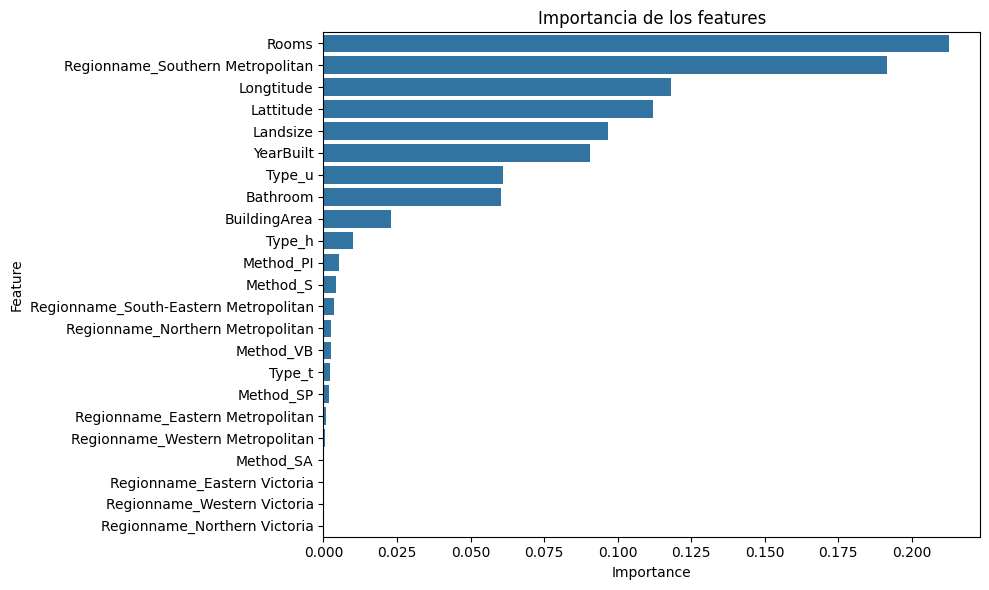

In [866]:
preprocessor = my_pipeline.named_steps['preprocessor']
model = my_pipeline.named_steps['model']

numerical_features = numerical_columns

categorical_features = preprocessor.transformers_[1][1].named_steps['onehot'].get_feature_names_out(low_cardinality_cols)

all_feature_names = numerical_features + list(categorical_features)

feature_importances = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(feature_importances)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Importancia de los features')
plt.tight_layout()
plt.show()

Surgen dudas de cuánto debería influir la categoría específica de "Southern Metropolitan", pero con un análisis en profundidad, observamos que es importante. <br />
Tiene muchos valores, por eso sirve al árbol de decisiones para tomar decisiones. En ese sentido es importante

In [867]:
print(df_clean['Regionname'].value_counts())
category_counts = df_clean.groupby('Regionname')['Price'].mean()
print(category_counts)


Regionname
Southern Metropolitan         2994
Northern Metropolitan         2460
Western Metropolitan          1837
Eastern Metropolitan           851
South-Eastern Metropolitan     249
Eastern Victoria                33
Northern Victoria               29
Western Victoria                24
Name: count, dtype: int64
Regionname
Eastern Metropolitan          1.096872e+06
Eastern Victoria              6.775752e+05
Northern Metropolitan         8.752838e+05
Northern Victoria             6.106207e+05
South-Eastern Metropolitan    9.229839e+05
Southern Metropolitan         1.367357e+06
Western Metropolitan          8.629426e+05
Western Victoria              4.034792e+05
Name: Price, dtype: float64


In [868]:
from sklearn.inspection import permutation_importance

result = permutation_importance(my_pipeline, val_X, val_y, n_repeats=10, random_state=42)

feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': result.importances_mean
}).sort_values(by='Importance', ascending=False)

print(feature_importances)

        Feature  Importance
9    Regionname    0.529740
0         Rooms    0.326365
6    Longtitude    0.295932
5     Lattitude    0.280544
2      Landsize    0.134664
7          Type    0.096742
1      Bathroom    0.068729
4     YearBuilt    0.058958
8        Method    0.004297
3  BuildingArea   -0.000723


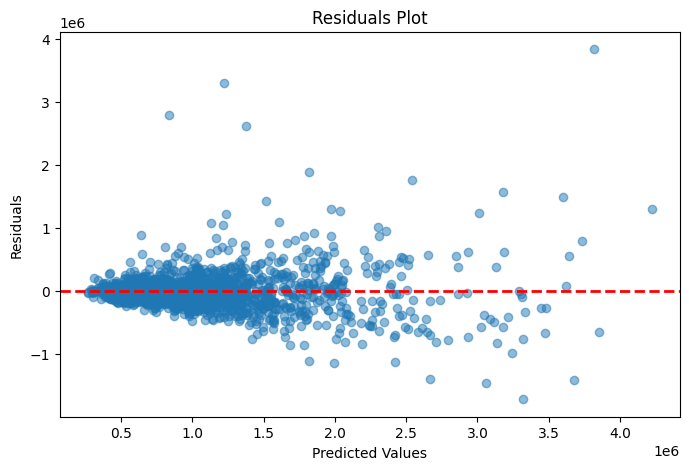

In [869]:
residuals = val_y - preds

plt.figure(figsize=(8, 5))
plt.scatter(preds, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.show()

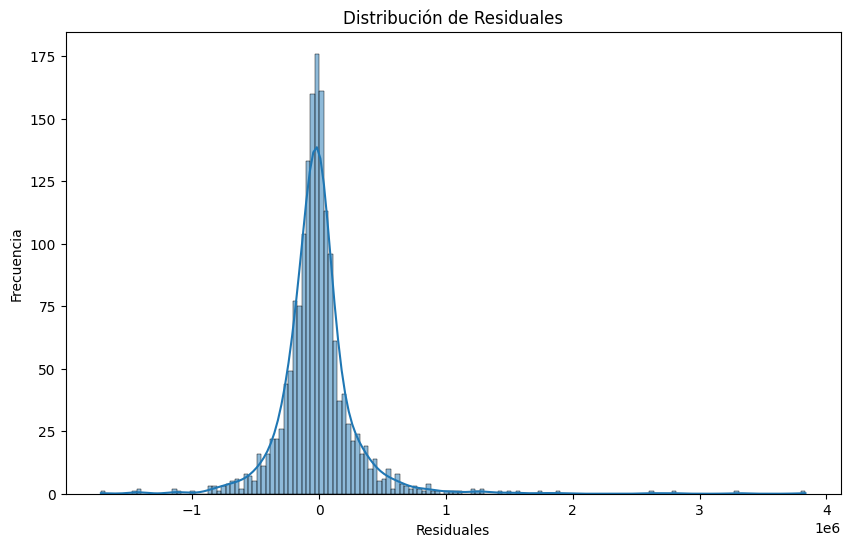

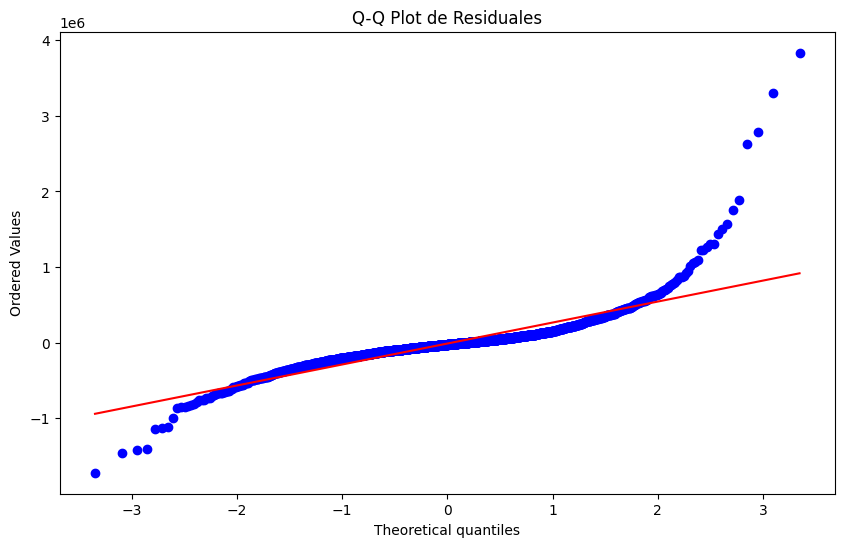

In [870]:
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title("Distribución de Residuales")
plt.xlabel("Residuales")
plt.ylabel("Frecuencia")
plt.show()

plt.figure(figsize=(10, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot de Residuales")
plt.show()

Como podemos ver en el gráfico, tenemos cierta skewness (asimetría) a derecha. Pero es con valores reales de los datos, por lo cual no los eliminaremos del análisis

In [871]:
residuals_df = pd.DataFrame({'Residuals': residuals, 'Predicted Values': preds})

std_dev = residuals_df['Residuals'].std()
threshold = 2 * std_dev
far_residuals_df = residuals_df[np.abs(residuals_df['Residuals']) > threshold]

far_residual_indices = far_residuals_df.index.intersection(val_X.index)

far_val_X = val_X.loc[far_residual_indices]
far_val_y = val_y.loc[far_residual_indices]

far_data_df = pd.DataFrame(far_val_X)
far_data_df['Actual_Target'] = far_val_y
far_data_df['Residuals'] = far_residuals_df.loc[far_residual_indices, 'Residuals']
far_data_df['Predicted_Target'] = far_residuals_df.loc[far_residual_indices, 'Predicted Values']

far_data_df

,Rooms,Bathroom,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Type,Method,Regionname,Actual_Target,Residuals,Predicted_Target
5412,3,1.0,331.0,65.0,1960.0,-37.82630,145.00850,h,SP,Northern Metropolitan,2055000.0,774360.0,1280640.0
11004,4,2.0,558.0,120.0,1900.0,-37.88014,144.99347,h,S,Southern Metropolitan,3175000.0,863145.6,2311854.4
13521,4,3.0,123.0,120.0,2010.0,-37.83349,144.94840,t,SP,Southern Metropolitan,2455000.0,661190.0,1793810.0
9575,4,2.0,1690.0,120.0,1863.0,-37.82652,145.03052,h,S,Southern Metropolitan,7650000.0,3834060.0,3815940.0
5772,5,2.0,436.0,221.0,1910.0,-37.86180,144.98200,h,VB,Southern Metropolitan,2000000.0,-648250.0,2648250.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4742,2,2.0,0.0,91.0,2007.0,-37.83920,144.92570,u,S,Southern Metropolitan,1610000.0,693075.0,916925.0
10185,4,3.0,967.0,120.0,1996.0,-37.81792,145.06244,h,S,Southern Metropolitan,4750000.0,1572850.0,3177150.0
7608,4,3.0,0.0,108.0,2012.0,-37.77500,144.95130,h,VB,Northern Metropolitan,1900000.0,647160.0,1252840.0
2753,4,4.0,708.0,95.0,1985.0,-37.86460,145.06730,h,PI,Southern Metropolitan,1900000.0,-809505.0,2709505.0


<!-- ## Agregando variables categóricas al análisis
Utilizamos One-Hot Encoder, para transformar las variables categóricas en arrays de números, y agregar información al modelo. Va a performar mejor cuanta más información tenga. -->